# Exercício

Dado o dataset semelhate, mas com reviews de produtos comprados na Amazon, construa uma nuvem de palavras semelhante àquela feitap ara as compras do Mercado Livre.

A célula abaixo, baixa a base de dados para seu ambiente.

In [1]:
import nltk  # Biblioteca usada para o processamento de linguagem natural
import spacy  # Biblioteca para processamento de linguagem natural e análise de texto
import pandas as pd  # Biblioteca para manipulação e análise de dados estruturados
import matplotlib.pyplot as plt  # Biblioteca para criação de gráficos e visualizações
from wordcloud import WordCloud  # Biblioteca para gerar nuvens de palavras a partir de textos
from collections import Counter  # Biblioteca para contagem de elementos em iteráveis, útil para análise de frequência
from nltk.corpus import stopwords  # Módulo do NLTK que fornece uma lista de palavras comuns a serem ignoradas (stop words)
import gdown  # Biblioteca para baixar arquivos do Google Drive
import re  # Biblioteca para manipulação e busca de padrões em strings usando expressões regulares

In [2]:
# Download necessário para a NLTK
nltk.download('stopwords')  # Baixa a lista de stop words (palavras comuns) para uso no processamento de texto
nltk.download('punkt')  # Baixa o tokenizer Punkt, necessário para a tokenização de frases

# Carregar o modelo de português para o spaCy
!python -m spacy download pt_core_news_sm

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 44.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('pt_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


# Carregamento dos dados

In [3]:
# Amazon
url = 'https://drive.google.com/uc?id=1A8efRUQDYVXAZ4CEDhmLhDoVnkSOe5-Q'
output = 'am_dataset.csv'
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1A8efRUQDYVXAZ4CEDhmLhDoVnkSOe5-Q
To: /content/am_dataset.csv
100%|██████████| 3.32M/3.32M [00:00<00:00, 41.4MB/s]


'am_dataset.csv'

In [4]:
data = pd.read_csv(output, encoding='utf-8')

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9815 entries, 0 to 9814
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Search Query   9815 non-null   object
 1   Product Title  9815 non-null   object
 2   Link           9815 non-null   object
 3   Review         9815 non-null   object
dtypes: object(4)
memory usage: 306.8+ KB


In [6]:
data.head()

,Search Query,Product Title,Link,Review
0,smartphone,Smartphone Xiaomi Note 12 4G 128GB 6GB Ram (VE...,https://www.amazon.com.br/dp/B0BZ7RJDHD,Com a necessidade de comprar um celular custo ...
1,smartphone,Smartphone Xiaomi Note 12 4G 128GB 6GB Ram (VE...,https://www.amazon.com.br/dp/B0BZ7RJDHD,Minha experiência de 10 dias de uso com o Xiao...
2,smartphone,Smartphone Xiaomi Note 12 4G 128GB 6GB Ram (VE...,https://www.amazon.com.br/dp/B0BZ7RJDHD,"Smartphone de qualidade como já esperava, boas..."
3,smartphone,Smartphone Xiaomi Note 12 4G 128GB 6GB Ram (VE...,https://www.amazon.com.br/dp/B0BZ7RJDHD,atendeu mto minhas expectativas. Antes eu usa...
4,smartphone,Smartphone Xiaomi Note 12 4G 128GB 6GB Ram (VE...,https://www.amazon.com.br/dp/B0BZ7RJDHD,"Gostei muito do celular, tem resposta rápida e..."


## Pré-processamento de Texto
O pré-processamento inclui a limpeza e normalização dos textos dos tweets para prepará-los para a análise.

Vamos definir uma função para remover conteúdo considerado ruído, ou seja, URLs, caracteres utilizado para menções, pontuação e números. Além disso, é feita uma normalização básica com conversão para letras minúsculas. Isso é feito na função `remove_noise()`.

In [7]:
def remove_noise(text):

    # Converte para minúsculas
    text = text.lower()

    # Remove URLs
    # S+: corresponde a um ou mais caracteres que não são espaços em branco (o \S significa “qualquer caractere que não seja espaço em branco” e o + indica que deve haver um ou mais desses caracteres)
    text = re.sub(r'http\S+', '', text)

    # Remove menções e hashtags
    # @: corresponde ao caractere “@” usado para menções.
    # #: corresponde ao caractere “#” usado para hashtags.
    # |: operador “ou” que permite combinar dois padrões.
    # \w+: corresponde a um ou mais caracteres alfanuméricos (inclui letras e números).
    text = re.sub(r'@\w+|#\w+', '', text)

    # Remove pontuação
    # []: colchetes são usados para definir uma classe de caracteres.
    # ^: quando usado no início de uma classe de caracteres, o ^ nega a classe, ou seja, seleciona tudo que não está na classe.
    # \w: corresponde a qualquer caractere alfanumérico (letras e números, incluindo o caractere de sublinhado _)
    # \s: corresponde a qualquer espaço em branco (espaços, tabulações, quebras de linha).
    text = re.sub(r'[^\w\s]', '', text)

    # Remove números
    # \d: corresponde a qualquer dígito (de 0 a 9).
    # +: significa “um ou mais” do elemento precedente. Portanto, \d+ corresponde a uma sequência de um ou mais dígitos consecutivos.
    text = re.sub(r'\d+', '', text)

    return text

In [22]:
def remove_stopwords(text):
  # Obtém a lista de stopwords em português usando o NLTK e as converte para um conjunto para melhorar a eficiência da busca
  stop_words = set(stopwords.words('portuguese'))

  # Divide o texto em palavras, remove as stopwords e então junta as palavras restantes de volta em uma string
  text = ' '.join([word for word in text.split() if word not in stop_words])

  return text

# Remoção de stopwords em inglês

In [23]:
def remove_stopwords_eng(text):
  # Obtém a lista de stopwords em português usando o NLTK e as converte para um conjunto para melhorar a eficiência da busca
  stop_words = set(stopwords.words('english'))

  # Divide o texto em palavras, remove as stopwords e então junta as palavras restantes de volta em uma string
  text = ' '.join([word for word in text.split() if word not in stop_words])

  return text

In [21]:
# Aplicando a remoção de ruído
data['clean_review'] = data['Review'].apply(remove_noise)
data.head()

,Search Query,Product Title,Link,Review,clean_review,tokens
0,smartphone,Smartphone Xiaomi Note 12 4G 128GB 6GB Ram (VE...,https://www.amazon.com.br/dp/B0BZ7RJDHD,Com a necessidade de comprar um celular custo ...,com a necessidade de comprar um celular custo ...,"[necessidade, comprar, celular, custo, benefíc..."
1,smartphone,Smartphone Xiaomi Note 12 4G 128GB 6GB Ram (VE...,https://www.amazon.com.br/dp/B0BZ7RJDHD,Minha experiência de 10 dias de uso com o Xiao...,minha experiência de dias de uso com o xiaomi...,"[experiência, dias, uso, xiaomi, redmi, note, ..."
2,smartphone,Smartphone Xiaomi Note 12 4G 128GB 6GB Ram (VE...,https://www.amazon.com.br/dp/B0BZ7RJDHD,"Smartphone de qualidade como já esperava, boas...",smartphone de qualidade como já esperava boas ...,"[smartphone, qualidade, esperava, boas, config..."
3,smartphone,Smartphone Xiaomi Note 12 4G 128GB 6GB Ram (VE...,https://www.amazon.com.br/dp/B0BZ7RJDHD,atendeu mto minhas expectativas. Antes eu usa...,atendeu mto minhas expectativas antes eu usav...,"[atendeu, mto, expectativas, antes, usava, sam..."
4,smartphone,Smartphone Xiaomi Note 12 4G 128GB 6GB Ram (VE...,https://www.amazon.com.br/dp/B0BZ7RJDHD,"Gostei muito do celular, tem resposta rápida e...",gostei muito do celular tem resposta rápida em...,"[gostei, celular, resposta, rápida, todos, sen..."


In [24]:
# Aplicando a remoção de stopwords
data['clean_review'] = data['clean_review'].apply(remove_stopwords)
data['clean_review'] = data['clean_review'].apply(remove_stopwords_eng)
data.head()

,Search Query,Product Title,Link,Review,clean_review,tokens
0,smartphone,Smartphone Xiaomi Note 12 4G 128GB 6GB Ram (VE...,https://www.amazon.com.br/dp/B0BZ7RJDHD,Com a necessidade de comprar um celular custo ...,necessidade comprar celular custo benefício co...,"[necessidade, comprar, celular, custo, benefíc..."
1,smartphone,Smartphone Xiaomi Note 12 4G 128GB 6GB Ram (VE...,https://www.amazon.com.br/dp/B0BZ7RJDHD,Minha experiência de 10 dias de uso com o Xiao...,experiência dias uso xiaomi redmi note gb gb r...,"[experiência, dias, uso, xiaomi, redmi, note, ..."
2,smartphone,Smartphone Xiaomi Note 12 4G 128GB 6GB Ram (VE...,https://www.amazon.com.br/dp/B0BZ7RJDHD,"Smartphone de qualidade como já esperava, boas...",smartphone qualidade esperava boas configuraçõ...,"[smartphone, qualidade, esperava, boas, config..."
3,smartphone,Smartphone Xiaomi Note 12 4G 128GB 6GB Ram (VE...,https://www.amazon.com.br/dp/B0BZ7RJDHD,atendeu mto minhas expectativas. Antes eu usa...,atendeu mto expectativas antes usava samsung m...,"[atendeu, mto, expectativas, antes, usava, sam..."
4,smartphone,Smartphone Xiaomi Note 12 4G 128GB 6GB Ram (VE...,https://www.amazon.com.br/dp/B0BZ7RJDHD,"Gostei muito do celular, tem resposta rápida e...",gostei celular resposta rápida todos sentidos ...,"[gostei, celular, resposta, rápida, todos, sen..."


# Tokenização em palavras

In [25]:
# Cria uma lista de palavras, iterando por cada avaluiação em 'clean_review', dividindo cada resenha em palavras
words = [word for review in data['Review'] for word in review.split()]
# Conta a frequência de cada palavra na lista 'words' usando a função Counter da biblioteca collections, criando um dicionário onde as chaves são palavras e os valores são suas frequências
word_freq = Counter(words)
# Obtém as 10 palavras mais comuns e suas frequências, retornando uma lista de tuplas onde cada tupla contém uma palavra e sua contagem
most_common_words = word_freq.most_common(10)
# Imprime a lista das 10 palavras mais comuns e suas respectivas frequências
print('Palavras mais comuns:', most_common_words)

Palavras mais comuns: [('e', 8189), ('a', 7694), ('de', 7484), ('o', 6354), ('que', 5505), ('é', 5303), ('não', 3785), ('muito', 3469), ('the', 3312), ('com', 3125)]


In [26]:
from tqdm import tqdm
tqdm.pandas()

In [16]:
!pip install pandarallel
from pandarallel import pandarallel # import pandarallel
pandarallel.initialize(progress_bar=True) # initialize pandarallel

  Preparing metadata (setup.py) ... done
  Created wheel for pandarallel: filename=pandarallel-1.6.5-py3-none-any.whl size=16674 sha256=3df7ddc0e028f07a3dd0c16b75aa0fb4d989a4ae1cf67de0b0c60f05075e4eee
  Stored in directory: /root/.cache/pip/wheels/46/f9/0d/40c9cd74a7cb8dc8fe57e8d6c3c19e2c730449c0d3f2bf66b5
Successfully built pandarallel
INFO: Pandarallel will run on 1 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [27]:
def tokenize_text(text):
    doc = nlp(text)
    tokens = [token.text for token in doc]
    return tokens

# data['tokens'] = data['clean_review'].apply(tokenize_text)
data['tokens'] = data['clean_review'].progress_apply(tokenize_text)
# data['tokens'] = data['clean_review'].parallel_apply(tokenize_text)

100%|██████████| 9815/9815 [01:43<00:00, 94.42it/s]


In [28]:
data.head()

,Search Query,Product Title,Link,Review,clean_review,tokens
0,smartphone,Smartphone Xiaomi Note 12 4G 128GB 6GB Ram (VE...,https://www.amazon.com.br/dp/B0BZ7RJDHD,Com a necessidade de comprar um celular custo ...,necessidade comprar celular custo benefício co...,"[necessidade, comprar, celular, custo, benefíc..."
1,smartphone,Smartphone Xiaomi Note 12 4G 128GB 6GB Ram (VE...,https://www.amazon.com.br/dp/B0BZ7RJDHD,Minha experiência de 10 dias de uso com o Xiao...,experiência dias uso xiaomi redmi note gb gb r...,"[experiência, dias, uso, xiaomi, redmi, note, ..."
2,smartphone,Smartphone Xiaomi Note 12 4G 128GB 6GB Ram (VE...,https://www.amazon.com.br/dp/B0BZ7RJDHD,"Smartphone de qualidade como já esperava, boas...",smartphone qualidade esperava boas configuraçõ...,"[smartphone, qualidade, esperava, boas, config..."
3,smartphone,Smartphone Xiaomi Note 12 4G 128GB 6GB Ram (VE...,https://www.amazon.com.br/dp/B0BZ7RJDHD,atendeu mto minhas expectativas. Antes eu usa...,atendeu mto expectativas antes usava samsung m...,"[atendeu, mto, expectativas, antes, usava, sam..."
4,smartphone,Smartphone Xiaomi Note 12 4G 128GB 6GB Ram (VE...,https://www.amazon.com.br/dp/B0BZ7RJDHD,"Gostei muito do celular, tem resposta rápida e...",gostei celular resposta rápida todos sentidos ...,"[gostei, celular, resposta, rápida, todos, sen..."


# 20 Tokens mais frequentes

In [30]:
tokens = [token for review in data['tokens'] for token in review]
token_freq = Counter(tokens)
most_common_tokens = token_freq.most_common(20)
print('Tokens mais comuns:', most_common_tokens)

Tokens mais comuns: [('produto', 2290), ('bem', 2211), ('bom', 1986), ('qualidade', 1372), ('pra', 1087), ('boa', 1043), ('excelente', 1036), ('chegou', 944), ('ótimo', 909), ('recomendo', 907), ('gostei', 851), ('uso', 811), ('super', 774), ('pouco', 660), ('entrega', 643), ('camera', 634), ('comprei', 619), ('bateria', 608), ('rápido', 604), ('som', 604)]


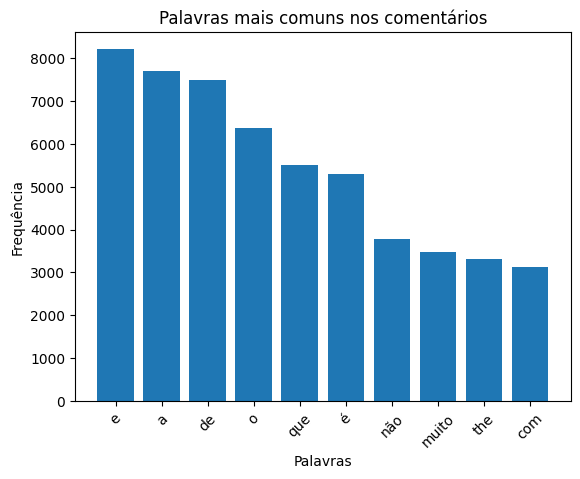

In [31]:
# Visualizando as palavras mais comuns
words, counts = zip(*most_common_words)
plt.bar(words, counts)
plt.xlabel('Palavras')
plt.ylabel('Frequência')
plt.xticks(rotation=45)
plt.title('Palavras mais comuns nos comentários')
plt.show()

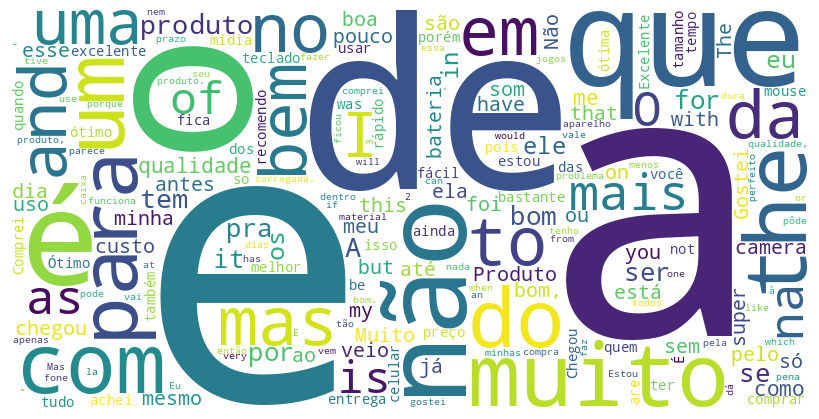

In [32]:
# Gerando uma nuvem de palavras a partir da frequência das palavras depois de tratado
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

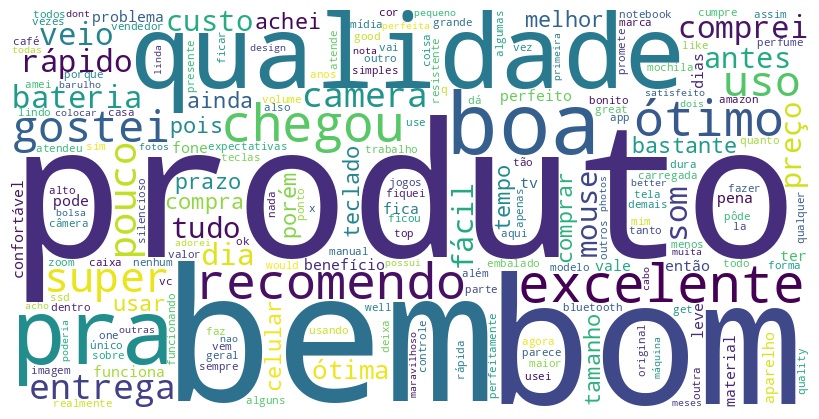

In [33]:
# Gerando uma nuvem de palavras a partir da frequência dos tokens
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(token_freq)
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

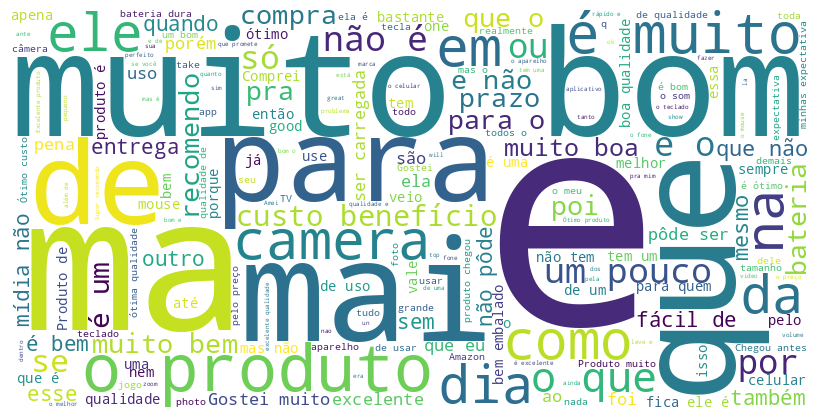

In [35]:
# Gerando uma nuvem de palavras a partir do texto deixando o WordCloud gerar as palavras
wordcloud = WordCloud(width = 800, height = 400, background_color ='white').generate(' '.join(data['Review']))
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

## Conclusão
Este notebook apresentou um fluxo de trabalho básico para o pré-processamento, análise e visualização de dados textuais em português, usando técnicas básicas de PLN. As técnicas demonstradas aqui são fundamentais para extrair insights significativos de dados textuais.

(Observa-se que para o banco de dados da Amazon foi necessário remover stopwords em inglês também, pois stopwords como "the" estavam aparecendo entre os tokens)
